In [20]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ---------- Quintic Hermite utilities (2D) ----------
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import cvxpy as cp

# ---------- Quintic helpers ----------
def quintic_coeffs_numeric(p0, v0, a0, p1, v1, a1, T):
    T2,T3,T4,T5 = T**2, T**3, T**4, T**5
    M = np.array([[  T3,    T4,     T5],
                  [3*T2,  4*T3,   5*T4],
                  [6*T,  12*T2,  20*T3]], float)
    b = np.array([
        p1 - (p0 + v0*T + 0.5*a0*T2),
        v1 - (v0 + a0*T),
        a1 - a0
    ], float)
    c3,c4,c5 = np.linalg.solve(M, b)
    return np.array([p0, v0, 0.5*a0, c3, c4, c5], float)

def jerk_cost_closed_form_1d(c, T):
    c3,c4,c5 = c[3], c[4], c[5]
    a = (60*c5)**2
    b = 2*(60*c5)*(24*c4)
    c2 = (24*c4)**2 + 2*(60*c5)*(6*c3)
    d = 2*(24*c4)*(6*c3)
    e = (6*c3)**2
    return (a*T**5/5) + (b*T**4/4) + (c2*T**3/3) + (d*T**2/2) + (e*T)

def eval_quintic_vec(coeffs_xy, t):
    t = np.atleast_1d(t)
    tt = t[:, None]
    c0,c1,c2,c3,c4,c5 = [coeffs_xy[i] for i in range(6)]
    p = (((((c5*tt + c4)*tt + c3)*tt + c2)*tt + c1)*tt + c0)
    v = ((((5*c5*tt + 4*c4)*tt + 3*c3)*tt + 2*c2)*tt + c1)
    a = (((20*c5*tt + 12*c4)*tt + 6*c3)*tt + 2*c2)
    return p, v, a

def minimize_jerk_va(wps, T, v0=None, a0=None, vM=None, aM=None):
    """
    Min-jerk, C2. Uses cvxpy with sampled jerk cost (convex).
    """
    dim = wps[0].shape[0]
    n_seg = len(T)
    n_k   = n_seg + 1

    if v0 is None: v0 = np.zeros(dim)
    if a0 is None: a0 = np.zeros(dim)
    if vM is None: vM = np.zeros(dim)
    if aM is None: aM = np.zeros(dim)

    V = np.zeros((n_k, dim))
    A = np.zeros((n_k, dim))
    V[0], A[0] = v0, a0
    V[-1], A[-1] = vM, aM

    for axis in range(dim):
        n_int = n_k - 2
        if n_int <= 0:
            continue

        v_int = cp.Variable(n_int)
        a_int = cp.Variable(n_int)

        cost = 0
        for s in range(n_seg):
            Tm = float(T[s])  # ensure pure float
            T2,T3,T4,T5 = Tm**2, Tm**3, Tm**4, Tm**5

            # numeric inverse
            M_num = np.array([[  T3,    T4,     T5],
                              [3*T2,  4*T3,   5*T4],
                              [6*Tm, 12*T2,  20*T3]], dtype=float)
            Minv = np.linalg.inv(M_num)

            p0 = wps[s][axis]; p1 = wps[s+1][axis]

            v0s = V[s,axis]    if s==0        else v_int[s-1]
            a0s = A[s,axis]    if s==0        else a_int[s-1]
            v1s = V[s+1,axis]  if s==n_seg-1  else v_int[s]
            a1s = A[s+1,axis]  if s==n_seg-1  else a_int[s]

            rhs0 = p1 - (p0 + v0s*Tm + 0.5*a0s*T2)
            rhs1 = v1s - (v0s + a0s*Tm)
            rhs2 = a1s - a0s
            rhs  = cp.hstack([rhs0, rhs1, rhs2])   # cvxpy vector

            c3_5 = Minv @ rhs                       # affine cvxpy expr
            c0 = p0
            c1 = v0s
            c2 = 0.5*a0s
            # make a column vector of coeffs for convenience
            c = cp.hstack([c0, c1, c2, c3_5[0], c3_5[1], c3_5[2]])

            # jerk(t) = 60 c5 t^2 + 24 c4 t + 6 c3  (affine in c)
            tt = np.linspace(0, Tm, 15)  # integration samples
            dt = tt[1]-tt[0]
            j = 60*c[5]*tt**2 + 24*c[4]*tt + 6*c[3]
            cost += cp.sum_squares(j)*dt

        prob = cp.Problem(cp.Minimize(cost))
        prob.solve(solver=cp.OSQP, verbose=False)

        V[1:-1, axis] = v_int.value
        A[1:-1, axis] = a_int.value

    return V, A

def minimize_jerk_va_free(wps, T,
                          v_init=None, a_init=None,
                          fix_mask=None,
                          n_int_samples=15):
    """
    Min-jerk, C2, optimizing ALL knot v,a (2D).
    - wps: list[(2,)]
    - T: list[float]
    - v_init, a_init: optional initial guesses/values (len = n_knots, 2)
    - fix_mask: dict with boolean arrays 'v','a' (len = n_knots) indicating which to hold fixed
    - n_int_samples: samples per segment for jerk integral approximation
    returns V, A  (shape (n_knots,2))
    """
    import cvxpy as cp
    wps = [np.asarray(p, float) for p in wps]
    dim = 2
    n_seg = len(T)
    n_k = n_seg + 1

    # defaults
    if v_init is None: v_init = np.zeros((n_k, dim))
    if a_init is None: a_init = np.zeros((n_k, dim))
    if fix_mask is None:
        fix_mask = {'v': np.zeros(n_k, dtype=bool),
                    'a': np.zeros(n_k, dtype=bool)}

    V = np.zeros((n_k, dim))
    A = np.zeros((n_k, dim))

    for axis in range(dim):
        # create cvxpy variables for all knots
        v_var = cp.Variable(n_k)
        a_var = cp.Variable(n_k)

        constraints = []
        # apply fixed knots
        for i in range(n_k):
            if fix_mask['v'][i]:
                constraints.append(v_var[i] == v_init[i, axis])
            if fix_mask['a'][i]:
                constraints.append(a_var[i] == a_init[i, axis])

        cost = 0
        for s in range(n_seg):
            Tm = float(T[s])
            T2,T3,T4,T5 = Tm**2, Tm**3, Tm**4, Tm**5

            # numeric inverse
            M_num = np.array([[  T3,    T4,     T5],
                              [3*T2,  4*T3,   5*T4],
                              [6*Tm, 12*T2,  20*T3]], dtype=float)
            Minv = np.linalg.inv(M_num)

            p0 = wps[s][axis]
            p1 = wps[s+1][axis]

            v0s = v_var[s]
            a0s = a_var[s]
            v1s = v_var[s+1]
            a1s = a_var[s+1]

            rhs0 = p1 - (p0 + v0s*Tm + 0.5*a0s*T2)
            rhs1 = v1s - (v0s + a0s*Tm)
            rhs2 = a1s - a0s
            rhs  = cp.hstack([rhs0, rhs1, rhs2])

            c3_5 = Minv @ rhs
            c0 = p0
            c1 = v0s
            c2 = 0.5*a0s
            c3, c4, c5 = c3_5[0], c3_5[1], c3_5[2]

            # jerk(t) = 60 c5 t^2 + 24 c4 t + 6 c3
            tt = np.linspace(0, Tm, n_int_samples)
            dt = tt[1]-tt[0]
            j = 60*c5*tt**2 + 24*c4*tt + 6*c3
            cost += cp.sum_squares(j)*dt

        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.OSQP, verbose=False)

        V[:, axis] = v_var.value
        A[:, axis] = a_var.value

    return V, A


def quintic_hermite_coeff(p0, v0, a0, p1, v1, a1, T):
    """
    p(t) = c0 + c1 t + c2 t^2 + c3 t^3 + c4 t^4 + c5 t^5,  t in [0, T]
    All vectors are shape (2,).
    Returns coeffs with shape (6,2).
    """
    T2, T3, T4, T5 = T**2, T**3, T**4, T**5

    M = np.array([[  T3,    T4,     T5],
                  [3*T2,  4*T3,   5*T4],
                  [6*T,  12*T2,  20*T3]])
    b = np.vstack([
        (p1 - (p0 + v0*T + 0.5*a0*T2)),
        (v1 - (v0 + a0*T)),
        (a1 - a0)
    ])
    c3_5 = np.linalg.solve(M, b)
    c0 = p0
    c1 = v0
    c2 = 0.5*a0
    c3, c4, c5 = c3_5
    return np.vstack([c0, c1, c2, c3, c4, c5])

def eval_quintic(coeffs, t):
    t = np.atleast_1d(t)
    tt = t[:, None]
    c0,c1,c2,c3,c4,c5 = coeffs
    # p
    p = (((((c5*tt + c4)*tt + c3)*tt + c2)*tt + c1)*tt + c0)
    # v = dp/dt
    v = ((((5*c5*tt + 4*c4)*tt + 3*c3)*tt + 2*c2)*tt + c1)
    # a = dv/dt
    a = (((20*c5*tt + 12*c4)*tt + 6*c3)*tt + 2*c2)
    return p, v, a

@dataclass
class Segment:
    p0: np.ndarray
    v0: np.ndarray
    a0: np.ndarray
    p1: np.ndarray
    v1: np.ndarray
    a1: np.ndarray
    T: float
    coeffs: np.ndarray = None
    def build(self):
        self.coeffs = quintic_hermite_coeff(self.p0, self.v0, self.a0,
                                            self.p1, self.v1, self.a1, self.T)

In [21]:
# ---------- Example inputs ----------
# Waypoints in 2D
wps  = [np.array([0., 0.]),
        np.array([2., 1.]),
        np.array([4., 0.5]),
        np.array([6., 1.5])]
# velocities/accelerations at knots (zero here; replace with yours)
T_segments = [2.0, 2.0, 2.0]  # T_0, T_1, T_2

# vels, accs = minimize_jerk_va(wps, T_segments)
vels, accs = minimize_jerk_va_free(wps, T_segments)

print("vels:\n", vels)
print("accs:\n", accs)

# Build segments
segments = []
for s in range(len(T_segments)):
    seg = Segment(wps[s], vels[s], accs[s],
                  wps[s+1], vels[s+1], accs[s+1],
                  T_segments[s])
    seg.build()
    segments.append(seg)

# ---------- Sampling ----------
SAMPLES_PER_SEG = 60
pos_all, vel_all, acc_all = [], [], []
seg_ids = []
t_offset = 0.0
for s, seg in enumerate(segments):
    t_local = np.linspace(0, seg.T, SAMPLES_PER_SEG)
    p, v, a = eval_quintic(seg.coeffs, t_local)
    pos_all.append(p)
    vel_all.append(v)
    acc_all.append(a)
    seg_ids.append(np.full_like(t_local, s))
    t_offset += seg.T

pos_all = np.vstack(pos_all)  # (N,2)
vel_all = np.vstack(vel_all)
acc_all = np.vstack(acc_all)
seg_ids = np.hstack(seg_ids)

vels:
 [[ 1.          1.15467685]
 [ 1.         -0.08277567]
 [ 1.         -0.08277567]
 [ 1.          1.15467685]]
accs:
 [[ 1.45650244e-15 -6.80394475e-01]
 [-9.14597973e-16 -4.59759994e-01]
 [-2.81968609e-16  4.59759994e-01]
 [-2.73775364e-15  6.80394475e-01]]


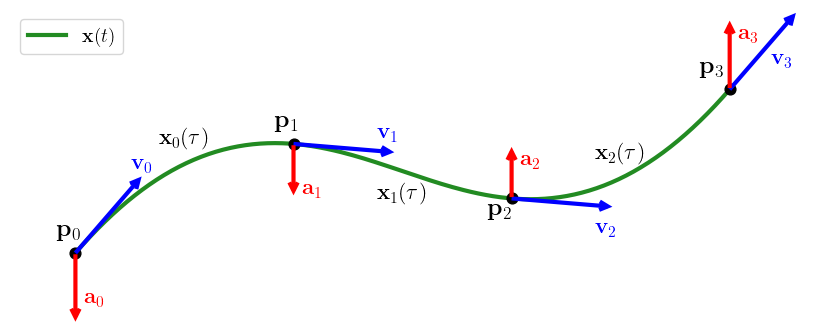

Figure saved to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/trajectory.pdf


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import font_manager

# --- fonts ---
font = font_manager.FontProperties()
font.set_family('serif')
font.set_size(30)
plt.rcParams.update({"text.usetex": True})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize=(8, 6))

# Trajectory
ax.plot(pos_all[:,0], pos_all[:,1], color='forestgreen', lw=3, zorder=1)

# Base limits from trajectory
pad = 0.10
x0, x1 = pos_all[:,0].min(), pos_all[:,0].max()
y0, y1 = pos_all[:,1].min(), pos_all[:,1].max()
dx, dy = x1-x0, y1-y0
ax.set_xlim(x0 - pad*dx, x1 + pad*dx)
ax.set_ylim(y0 - pad*dy, y1 + pad*dy)

# Data
wps_arr    = np.array(wps)
vel_knots  = np.array(vels)
acc_knots  = np.array(accs)

# Arrow length rules
traj_diag   = np.linalg.norm([dx, dy])
vel_max_len = 0.15 * traj_diag
acc_max_len = 0.10 * traj_diag
vel_min_len = 0.02 * traj_diag
acc_min_len = 0.02 * traj_diag

def draw_arrow(ax, start, vec, max_len, min_len, color, lw=3, z=6, offset=0.0):
    """Draw a single arrow, capped & floored in length, optional tail offset."""
    n = np.linalg.norm(vec)
    if n < 1e-12:
        # fallback direction
        vec = np.array([1.0, 0.0])
        n = 1.0
    scale = max(min_len / n, min(1.0, max_len / n))
    v = scale * vec
    # small offset so tail isn't under the waypoint dot
    if offset > 0:
        v_hat = v / (np.linalg.norm(v) + 1e-12)
        start = start + offset * v_hat
    end = start + v
    ann = ax.annotate(
        "", xy=end, xytext=start,
        arrowprops=dict(arrowstyle="->", lw=lw, color=color,
                        shrinkA=0, shrinkB=0,
                        joinstyle="miter", capstyle="butt",
                        mutation_scale=15),
        zorder=z,
        clip_on=False
    )
    return np.array([start, end])

# Waypoints (black circles) — draw *under* arrows so arrows show
wp_scat = ax.scatter(wps_arr[:,0], wps_arr[:,1], s=60, color='black', zorder=5)

# Draw velocity (blue) & acceleration (red) arrows
arrow_tips = []
for p, v in zip(wps_arr, vel_knots):
    arrow_tips.append(draw_arrow(ax, p, v, vel_max_len, vel_min_len, color='blue', lw=3, z=7, offset=0.0))
for idx, (p, a) in enumerate(zip(wps_arr, acc_knots)):
    # ensure the first arrow is visible: larger min_len + slight offset
    this_min = acc_min_len * (1.5 if idx == 0 else 1.0)
    arrow_tips.append(draw_arrow(ax, p, a, acc_max_len, this_min, color='red', lw=3, z=8, offset=0.002*traj_diag))

arrow_tips = np.vstack(arrow_tips)  # (2*#arrows, 2)

# Extend limits to include arrow heads
xt0, yt0 = arrow_tips.min(axis=0)
xt1, yt1 = arrow_tips.max(axis=0)
ax.set_xlim(min(ax.get_xlim()[0], xt0 - 0.02*dx), max(ax.get_xlim()[1], xt1 + 0.02*dx))
ax.set_ylim(min(ax.get_ylim()[0], yt0 - 0.02*dy), max(ax.get_ylim()[1], yt1 + 0.02*dy))

# Labels
label_fs = 18
Ts_fs    = 16
for s, seg in enumerate(segments):
    p_s = seg.p0
    ax.annotate(rf"$\mathbf{{p}}_{s}$", xy=p_s, xytext=(-18, -12) if s == 2 else (-14, 12),
                textcoords='offset points', fontsize=label_fs, color='black', zorder=9)  

    if s == 0:
        xy_text_vel = (40, 60)
    elif s == 1:
        xy_text_vel = (60, 4)
    else:
        xy_text_vel = (60, -25)

    ax.annotate(rf"$\mathbf{{v}}_{s}$", xy=p_s, xytext=xy_text_vel,
                textcoords='offset points', fontsize=label_fs-2, color='blue', zorder=9)
    ax.annotate(rf"$\mathbf{{a}}_{s}$", xy=p_s, xytext=(6,-36) if s != 2 else (6, 24),
                    textcoords='offset points', fontsize=label_fs-2, color='red', zorder=9)

    mid_t = seg.T/2
    p_mid, _, _ = eval_quintic(seg.coeffs, mid_t)
    p_mid = p_mid[0]
    ax.annotate(rf"$\mathbf{{x}}_{s}(\tau)$", xy=p_mid, xytext=(0, 14) if s != 1 else (0, -20),
                textcoords='offset points', fontsize=Ts_fs, color='black', ha='center', zorder=9)

# Last knot labels
last = len(segments)
p_last = segments[-1].p1
ax.annotate(rf"$\mathbf{{p}}_{last}$", xy=p_last, xytext=(-22, 12),
            textcoords='offset points', fontsize=label_fs, color='black', zorder=9)
ax.annotate(rf"$\mathbf{{v}}_{last}$", xy=p_last, xytext=(30,18),
            textcoords='offset points', fontsize=label_fs-2, color='blue', zorder=9)
ax.annotate(rf"$\mathbf{{a}}_{last}$", xy=p_last, xytext=(6,36),
            textcoords='offset points', fontsize=label_fs-2, color='red', zorder=9)
# no a_last

# Legend
traj_handle = Line2D([], [], color='forestgreen', lw=3, label=rf"$\mathbf{{x}}(t)$")
vel_handle = Line2D([], [], lw=3, color='blue',  label='velocity')
acc_handle = Line2D([], [], lw=3, color='red',   label='acceleration')
wp_handle  = Line2D([], [], marker='o', color='black', linestyle='None', markersize=8, label='waypoint')
ax.legend(handles=[traj_handle],
          loc='best', fontsize=14)

# Final cosmetics
ax.set_aspect('equal', 'box')
ax.set_axis_off()
plt.tight_layout(pad=0.0)
plt.show()

# save this as a PDF
file_path = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/trajectory.pdf"
fig.savefig(file_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
print(f"Figure saved to {file_path}")
# End of code


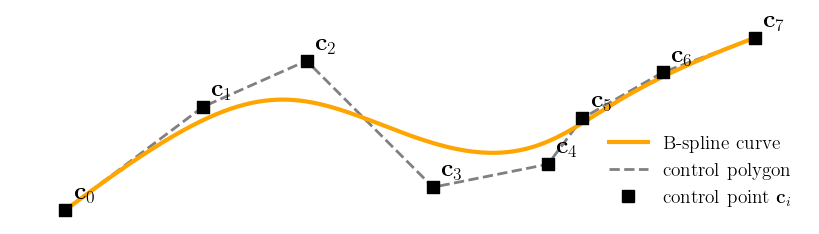

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import font_manager
from scipy.interpolate import BSpline

# ==============================
# Inputs
# ==============================
# 3 segments, quintic (degree 5)  -> need n_ctrl = segs + degree = 3 + 5 = 8 control points
control_pts = np.array([[0.0, 0.0],
                        [1.2, 0.9],
                        [2.1, 1.3],
                        [3.2, 0.2],
                        [4.2, 0.4],
                        [4.5, 0.8],
                        [5.2, 1.2],
                        [6., 1.5]])  # (8,2)


degree = 5
n_ctrl = control_pts.shape[0]
n_seg  = 3                      # we want exactly 3 polynomial pieces

# Durations per segment (time you want to show)
T_segments = [2.0, 2.0, 2.0]    # example
cumT = np.insert(np.cumsum(T_segments), 0, 0.0)  # [0,2,4,6]

# Open-uniform knot vector for p=5 and 3 spans in [0,1]
# 0 repeated p+1, then internal knots (#spans-1 = 2), then 1 repeated p+1
internal = np.linspace(0, 1, n_seg+1)[1:-1]  # (1/3, 2/3)
knots = np.concatenate([np.zeros(degree+1), internal, np.ones(degree+1)])

# Build spline
spl = BSpline(knots, control_pts, degree, axis=0)

# Sample curve for plotting
u_sample = np.linspace(knots[degree], knots[-degree-1], 400)  # valid param range
curve_xy = spl(u_sample)

# Internal knots for plotting markers (unique values)
internal_knots = np.unique(knots[degree:-degree])
knot_xy = spl(internal_knots)

# Mid-parameter of each span for T_s label
# spans: [knots[p+i], knots[p+i+1]], i=0..n_seg-1
span_u = []
for i in range(n_seg):
    u0 = knots[degree + i]
    u1 = knots[degree + i + 1]
    span_u.append(0.5*(u0 + u1))
span_u = np.array(span_u)
span_mid_pts = spl(span_u)

# ==============================
# Plot
# ==============================
# Fonts
font = font_manager.FontProperties()
font.set_family('serif')
font.set_size(30)
plt.rcParams.update({"text.usetex": True})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize=(8, 6))

# B-spline curve (orange)
curve_handle, = ax.plot(curve_xy[:,0], curve_xy[:,1],
                        color='orange', lw=3, zorder=2, label='B-spline curve')

# Control polygon (gray dashed)
ax.plot(control_pts[:,0], control_pts[:,1], '--', color='0.5', lw=2, zorder=1)

# Control points (black squares)
cp_scat = ax.scatter(control_pts[:,0], control_pts[:,1],
                     s=70, color='black', marker='s', zorder=4)
for i, p in enumerate(control_pts):
    ax.annotate(rf"$\mathbf{{c}}_{i}$", xy=p, xytext=(6, 8),
                textcoords='offset points', fontsize=18, color='black', zorder=5)

# Knot locations (purple triangles)
# ax.scatter(knot_xy[:,0], knot_xy[:,1],
#            s=60, marker='^', color='purple', zorder=5)
# for j, (uval, pt) in enumerate(zip(internal_knots, knot_xy)):
#     ax.annotate(rf"$u_{j}$", xy=pt, xytext=(6, -16),
#                 textcoords='offset points', fontsize=16, color='purple', zorder=6)

# Legend
poly_handle  = Line2D([], [], color='0.5', lw=2, ls='--', label='control polygon')
cp_handle    = Line2D([], [], marker='s', color='black', linestyle='None',
                      markersize=8, label='control point $\mathbf{c}_i$')
knot_handle  = Line2D([], [], marker='^', color='purple', linestyle='None',
                      markersize=8, label='knot $u_j$')

ax.legend(handles=[curve_handle, poly_handle, cp_handle],
          loc='best', fontsize=14, frameon=False)

# Cosmetics
pad = 0.08
x0, x1 = curve_xy[:,0].min(), curve_xy[:,0].max()
y0, y1 = curve_xy[:,1].min(), curve_xy[:,1].max()
dx, dy = x1-x0, y1-y0
ax.set_xlim(x0 - pad*dx, x1 + pad*dx)
ax.set_ylim(y0 - pad*dy, y1 + pad*dy)
ax.set_aspect('equal', 'box')
ax.set_axis_off()
plt.tight_layout(pad=0.0)
plt.show()


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import font_manager

# ---------- font ----------
font = font_manager.FontProperties()
font.set_family('serif')
font.set_size(30)
plt.rcParams.update({"text.usetex": True})
plt.rcParams["font.family"] = "Times New Roman"

# ---------- figure ----------
fig, ax = plt.subplots(figsize=(8, 6))

# 1) Trajectory
ax.plot(pos_all[:,0], pos_all[:,1], color='forestgreen', lw=3, zorder=1)

# Limits from trajectory
pad = 0.10
x0, x1 = pos_all[:,0].min(), pos_all[:,0].max()
y0, y1 = pos_all[:,1].min(), pos_all[:,1].max()
dx, dy = x1 - x0, y1 - y0
ax.set_xlim(x0 - pad*dx, x1 + pad*dx)
ax.set_ylim(y0 - pad*dy, y1 + pad*dy)

# 2) Waypoints as black circles
wps_arr = np.array(wps)
wp_scat = ax.scatter(wps_arr[:,0], wps_arr[:,1], s=60, color='black', zorder=5)

# 3) Coefficient labels along each segment
#    We'll sample 6 evenly spaced local times t in [0,T], one per coefficient index.
coef_names = [r"$\mathbf{c}_0$", r"$\mathbf{c}_1$", r"$\mathbf{c}_2$",
              r"$\mathbf{c}_3$", r"$\mathbf{c}_4$", r"$\mathbf{c}_5$"]

label_fs = 16
show_values = False  # set True to display numeric (x,y) too

for s, seg in enumerate(segments):
    # six sample params between 0 and T (avoid endpoints to reduce overlap with knots)
    ts = np.linspace(0.1*seg.T, 0.9*seg.T, 6)
    # positions on curve for placing labels
    pts, _, _ = eval_quintic_vec(seg.coeffs, ts)

    for i, (pt, name) in enumerate(zip(pts, coef_names)):
        if show_values:
            cx, cy = seg.coeffs[i,0], seg.coeffs[i,1]
            text = rf"{name}^{{({s})}} = ({cx:.2e},\,{cy:.2e})"
        else:
            text = rf"{name}^{{({s})}}"
        # slight alternating vertical offsets to reduce overlap
        dy_off = (8 if i%2==0 else -18)
        ax.annotate(text, xy=pt, xytext=(0, dy_off),
                    textcoords='offset points', fontsize=label_fs,
                    color='black', ha='center', zorder=9)

    # ---- T_s label at segment midpoint (like you had) ----
    mid_t = seg.T/2
    p_mid, _, _ = eval_quintic_vec(seg.coeffs, np.array([mid_t]))
    p_mid = p_mid[0]
    off = (0, 14) if s != 1 else (0, -20)
    ax.annotate(rf"$T_{s}$", xy=p_mid, xytext=off,
                textcoords='offset points', fontsize=label_fs,
                color='black', ha='center', zorder=9)

# 4) Legend
traj_handle = Line2D([], [], color='forestgreen', lw=3, label='trajectory')
wp_handle   = Line2D([], [], marker='o', color='black', linestyle='None',
                     markersize=8, label='waypoint')
coef_handle = Line2D([], [], color='black', lw=0, label=r'coefficients $\mathbf{c}_i^{(s)}$')
time_handle = Line2D([], [], color='black', lw=0, label=r'segment time $T_s$')

ax.legend(handles=[traj_handle, wp_handle, coef_handle, time_handle],
          loc='best', fontsize=14, frameon=False)

# 5) Final cosmetics
ax.set_aspect('equal', 'box')
ax.set_axis_off()
plt.tight_layout(pad=0.0)
plt.show()


RuntimeError: latex was not able to process the following string:
b'$\\\\mathbf{c}_0$^{(0)}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpuzjukptn 5f8e75b2ca868c08d5646b78f53c81bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./5f8e75b2ca868c08d5646b78f53c81bb.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 5f8e75b2ca868c08d5646b78f53c81bb.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.29 {\rmfamily $\mathbf{c}_0$^
                               {(0)}}%
No pages of output.
Transcript written on tmpuzjukptn/5f8e75b2ca868c08d5646b78f53c81bb.log.




Error in callback <function _draw_all_if_interactive at 0x7e328bbb5ea0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'$\\\\mathbf{c}_0$^{(0)}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpz49x8i3u 5f8e75b2ca868c08d5646b78f53c81bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./5f8e75b2ca868c08d5646b78f53c81bb.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 5f8e75b2ca868c08d5646b78f53c81bb.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.29 {\rmfamily $\mathbf{c}_0$^
                               {(0)}}%
No pages of output.
Transcript written on tmpz49x8i3u/5f8e75b2ca868c08d5646b78f53c81bb.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\mathbf{c}_0$^{(0)}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp3sbqs635 5f8e75b2ca868c08d5646b78f53c81bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./5f8e75b2ca868c08d5646b78f53c81bb.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 5f8e75b2ca868c08d5646b78f53c81bb.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.29 {\rmfamily $\mathbf{c}_0$^
                               {(0)}}%
No pages of output.
Transcript written on tmp3sbqs635/5f8e75b2ca868c08d5646b78f53c81bb.log.




<Figure size 800x600 with 1 Axes>

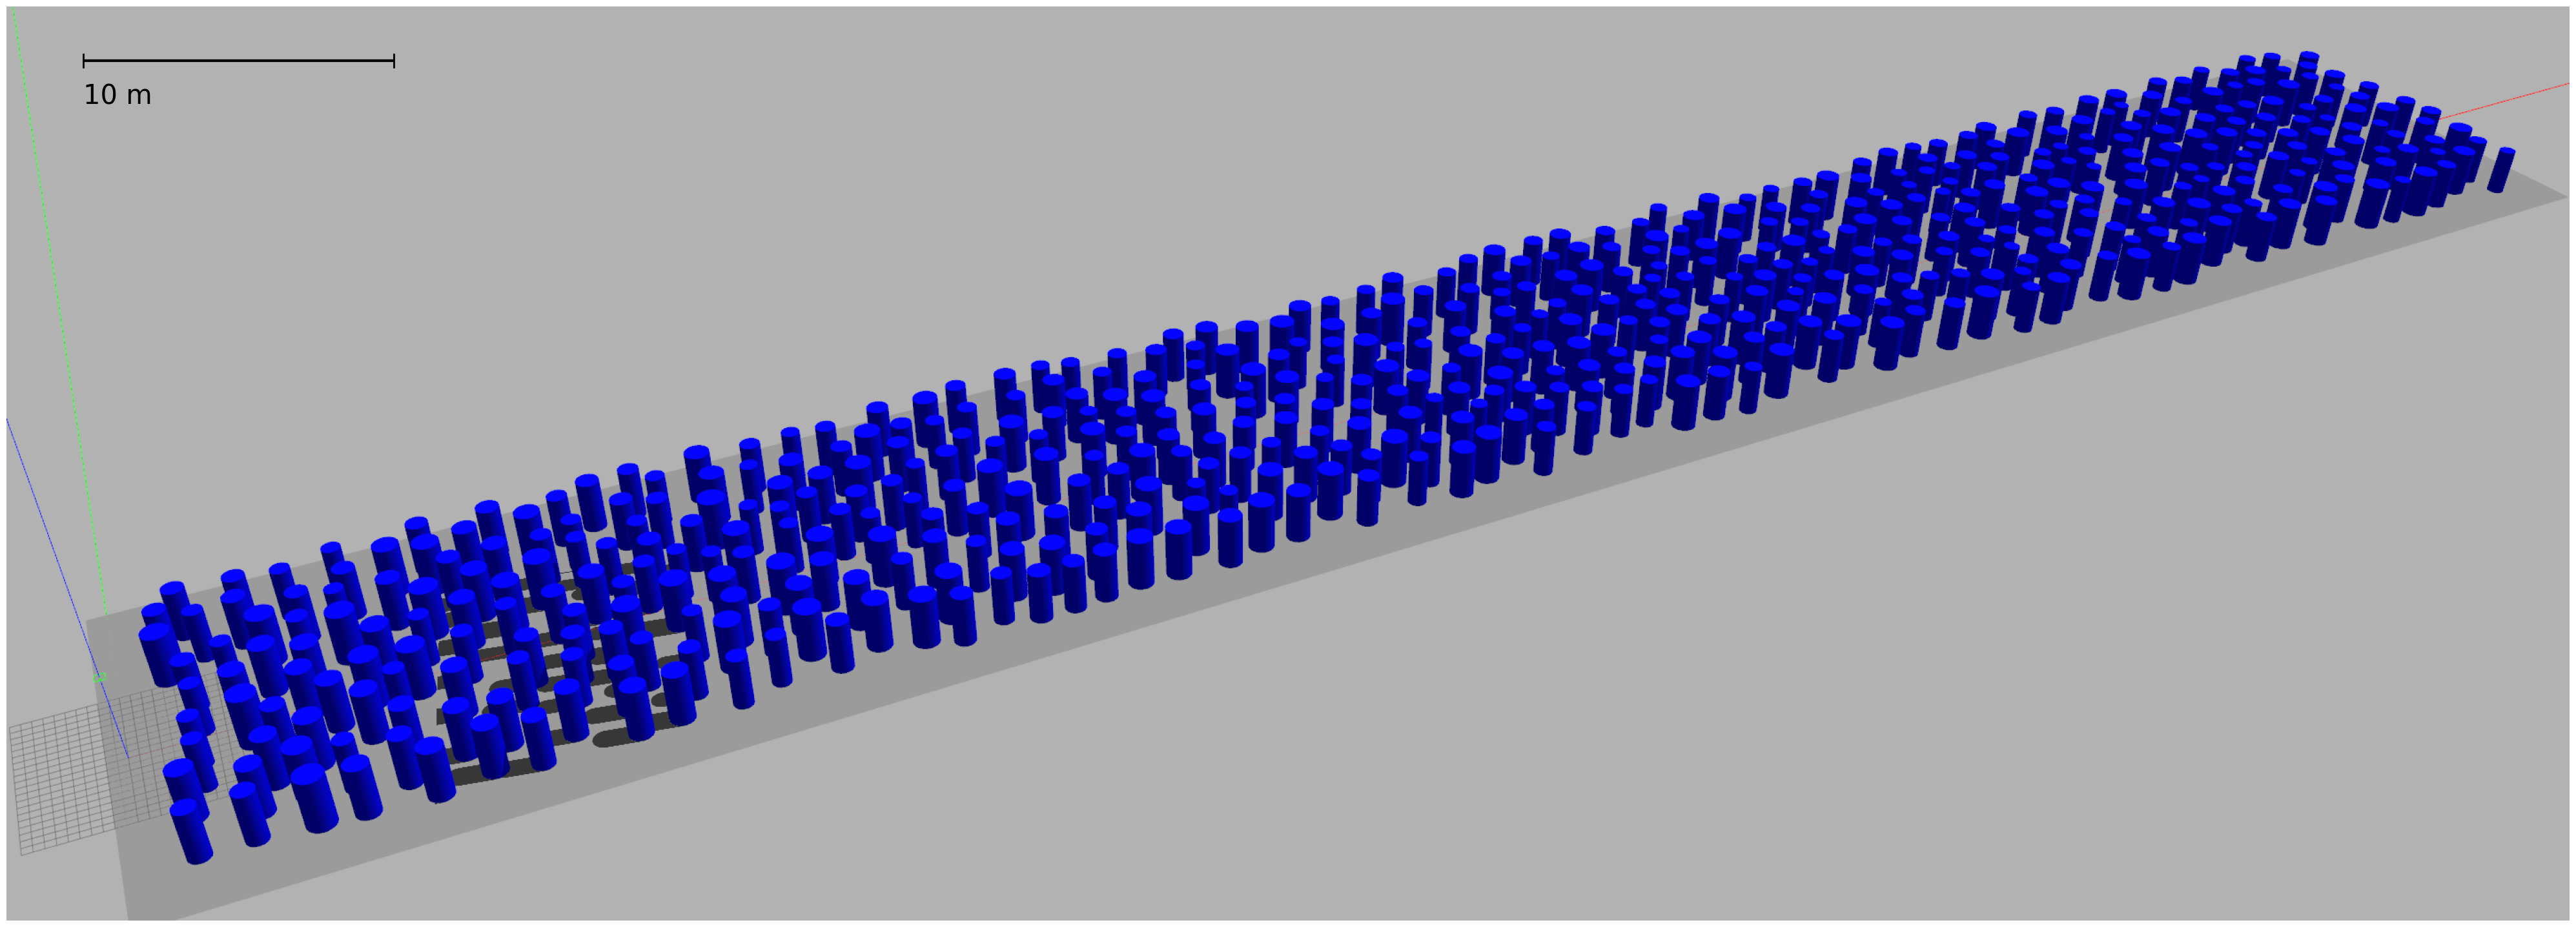

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import patheffects as pe

plt.style.use('default')

# ---------------- User setting: image scale ----------------
# How many pixels correspond to 1 meter in this Gazebo top-down image?
PIXELS_PER_METER = 35.0   # <-- adjust to your image's scale

# Load images
folder_path = "/media/kkondo/kota_elements/mighty/benchmark/hard_forest"
gazebo_image = plt.imread(folder_path + '/hard_forest_gazebo.png')

# Create a figure
fig_size_x = 40
fig_size_y = fig_size_x / 2.5
fig = plt.figure(figsize=(fig_size_x, fig_size_y))

# Crop the image (unchanged)
gazebo_image = gazebo_image[200:gazebo_image.shape[0] - 200,
                            400:gazebo_image.shape[1] - 100]

# Show the image
ax_gazebo = fig.add_subplot(1, 1, 1)
im = ax_gazebo.imshow(gazebo_image)  # origin='upper' by default (top-left is (0,0))
ax_gazebo.axis('off')

# ---------------- Add a 10 m scale bar (top-left) ----------------
h, w = gazebo_image.shape[:2]

# Bar config
bar_meters = 10.0
bar_px = bar_meters * PIXELS_PER_METER

# Margins from edges in pixels
left_pad_px = int(0.03 * w)
top_pad_px  = int(0.06 * h)

# If it doesn't fit, shrink to fit and update the text to the actual meters
if bar_px > (w - 2 * left_pad_px):
    bar_px = (w - 2 * left_pad_px)
    bar_meters = bar_px / PIXELS_PER_METER

x0 = left_pad_px
x1 = x0 + bar_px / 2
y  = top_pad_px

tick_h = max(6, int(0.015 * h))  # end tick height in px

# White stroke with black outline to ensure visibility
stroke = [pe.withStroke(linewidth=5, foreground='black')]

ax_gazebo.plot([x0, x1], [y, y], color='black', linewidth=3, solid_capstyle='butt', zorder=5)
ax_gazebo.plot([x0, x0], [y - tick_h/2, y + tick_h/2], color='black', linewidth=2, zorder=5)
ax_gazebo.plot([x1, x1], [y - tick_h/2, y + tick_h/2], color='black', linewidth=2, zorder=5)

# Label just below the bar
ax_gazebo.text(x0, y + tick_h + 10, f'{bar_meters:.0f} m', color='black', fontsize=60, va='top')

plt.tight_layout()

# Save
plt.savefig("/media/kkondo/kota_elements/mighty/benchmark/hard_forest/hard_forest_gazebo_trimmed.png",
            bbox_inches='tight', dpi=300)
plt.savefig("/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/hard_forest/hard_forest_gazebo_trimmed.png",
            bbox_inches='tight', dpi=300)
